# IMPORT İŞLEMLERİ

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import xgboost as xgb

# VERİ SETİNİN YÜKLENMESİ

In [ ]:
# Kaggle veri setini çekmek için gerekli kütüphane
!pip install kagglehub[pandas-datasets]

import kagglehub
from kagglehub import KaggleDatasetAdapter

# energy_dataset.csv dosyasını çekmek için
file_path = "energy_dataset.csv"

df_energy = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "nicholasjhana/energy-consumption-generation-prices-and-weather",
    file_path,
)

# weather_features.csv dosyasını çekmek için
file_path_weather = "weather_features.csv"

df_weather = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "nicholasjhana/energy-consumption-generation-prices-and-weather",
    file_path_weather,
)

# Veriler incelemek için
print("Energy Verisi:\n", df_energy.head())
print("Weather Verisi:\n", df_weather.head())

# VERİ SETİNİ PREPROCESSLEME (BİRLEŞTİRME + TEMİZLİK)

df_weather içinde her şehir için farklı değerler olması duplicate veri olmasına sebep oluyor. Bu nedenle verilerin ortalaması alınarak ilerlendi

In [ ]:
import pandas as pd

# 1. Tarih formatlarını düzenle
df_weather["datetime"] = pd.to_datetime(df_weather["dt_iso"], utc=True)
df_energy["datetime"] = pd.to_datetime(df_energy["time"], utc=True)

# 2. Weather verilerini datetime'a göre grupla ve ortalamaları al
df_weather_avg = df_weather.groupby("datetime")[["temp", "humidity", "wind_speed"]].mean().reset_index()

# 3. Verileri birleştir
df_merged = pd.merge(df_energy, df_weather_avg, on="datetime", how="inner")

# 4. Sadece gerekli sütunları seç
df_merged = df_merged[["datetime", "total load actual", "temp", "humidity", "wind_speed"]]

# 5. Eksik veri varsa doldur
df_merged = df_merged.ffill().bfill()

# Son kontrol
print(df_merged.head())
print("Veri şekli:", df_merged.shape)


In [ ]:
df.to_csv("hazirlanmis_veri.csv", index=False)
print("✅ CSV dosyası başarıyla oluşturuldu.")

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

import numpy as np
df = pd.read_csv('/content/drive/MyDrive/hazirlanmis_veri.csv')

In [ ]:
# --- 1. VERİ HAZIRLAMA ---
df = pd.read_csv('hazirlanmis_veri.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)
df = df.dropna(subset=['total load actual'])

#TÜREV HESAPLAMA

In [ ]:
# Türev ve hız
df['slope'] = df['total load actual'].diff()
df['acceleration'] = df['slope'].diff()
df = df.dropna().reset_index(drop=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# NORMALİZASYON

Min-Max Normalizasyonu: Değerleri [0, 1] aralığına çeker.

Z-score (Standart Skor): Ortalama 0, standart sapma 1 olacak şekilde dönüştürür.

Burada LSTM gibi sinir ağı tabanlı bir modelle çalışacağımız için genellikle Min-Max normalization daha yaygındır.

In [ ]:
scaler = MinMaxScaler()
df['target_scaled'] = scaler.fit_transform(df[['total load actual']])

# Zaman öznitelikleri

In [ ]:
# Zaman öznitelikleri
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek
df['rolling_mean'] = df['total load actual'].rolling(6).mean().fillna(method='bfill')


# LSTM + HİBRİT DENEYSEL VARYASYONLARI

In [ ]:

# --- 2. DENEY VARYASYONLARI TANIMLA ---
experiments = [
    # (exp_name, lookback, lstm_units, threshold_multiplier, extra_feats)
    ('V1_Lookback12',      12, 64, 2.0, ['lstm_pred', 'slope', 'acceleration', 'hour', 'dayofweek']),
    ('V2_Lookback48',      48, 64, 2.0, ['lstm_pred', 'slope', 'acceleration', 'hour', 'dayofweek']),
    ('V3_LSTMunits64',    24, 128,2.0, ['lstm_pred', 'slope', 'acceleration', 'hour', 'dayofweek']),
    ('V3_LSTMunits128',    24, 64, 2.0, ['lstm_pred', 'slope', 'acceleration', 'hour', 'dayofweek']),
    ('V4_ExtraFeature',    24, 64, 2.0, ['lstm_pred', 'slope', 'acceleration', 'hour', 'dayofweek', 'rolling_mean']),
    ('V5_ThresholdLow',    24, 64, 1.0, ['lstm_pred', 'slope', 'acceleration', 'hour', 'dayofweek']),
    ('V5_ThresholdMid',    24, 64, 1.5, ['lstm_pred', 'slope', 'acceleration', 'hour', 'dayofweek']),
    ]

results = []

# --- 3. DENEYSEL DÖNGÜ ---
for exp_name, lookback, lstm_units, th_mult, feat_cols in experiments:
    # Window dataset
    def create_windowed_dataset(series, lookback):
        X, y = [], []
        for i in range(len(series) - lookback):
            X.append(series[i:i+lookback])
            y.append(series[i+lookback])
        return np.array(X), np.array(y)
    X_all, y_all = create_windowed_dataset(df['target_scaled'].values, lookback)
    split_idx = int(len(X_all) * 0.8)
    X_train, X_test = X_all[:split_idx], X_all[split_idx:]
    y_train, y_test = y_all[:split_idx], y_all[split_idx:]

    # LSTM Model
    tf.keras.backend.clear_session()
    model = Sequential([
        LSTM(lstm_units, return_sequences=False, input_shape=(lookback, 1)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer='adam')

    # EARLY STOPPING callback'i ekliyoruz
    early_stopping = EarlyStopping(
        monitor='val_loss',         # doğrulama setindeki loss takibi
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        X_train[..., None], y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=0
    )

    best_epoch = len(history.history['loss'])

    lstm_pred_train = model.predict(X_train[..., None]).squeeze()
    lstm_pred_test = model.predict(X_test[..., None]).squeeze()

    # Ani değişim maskesi (test seti için)
    test_indices = np.arange(lookback + split_idx, lookback + split_idx + len(X_test))
    slope_th = df['slope'].std() * th_mult
    acc_th = df['acceleration'].std() * th_mult
    mask_test = (df.loc[test_indices, 'slope'].abs() > slope_th) | (df.loc[test_indices, 'acceleration'].abs() > acc_th)
    correction_indices = np.where(mask_test)[0]

    # Correction features
    df['lstm_pred'] = np.nan
    df.loc[test_indices, 'lstm_pred'] = lstm_pred_test

    correction_X = []
    correction_y = []
    for i, is_anom in enumerate(mask_test):
        if is_anom:
            idx = test_indices[i]
            feats = df.loc[idx, feat_cols].values
            real = df.loc[idx, 'target_scaled']
            lstm_pred = df.loc[idx, 'lstm_pred']
            correction_X.append(feats)
            correction_y.append(real - lstm_pred)
    correction_X = np.array(correction_X)
    correction_y = np.array(correction_y)

    # Correction Model
    xgb_model = xgb.XGBRegressor()
    if len(correction_X) > 0:
        xgb_model.fit(correction_X, correction_y)

    # Final Tahmin
    final_pred_test = lstm_pred_test.copy()
    for i, is_anom in enumerate(mask_test):
        if is_anom:
            idx = test_indices[i]
            feats = df.loc[idx, feat_cols].values.reshape(1, -1)
            correction = xgb_model.predict(feats)[0]
            final_pred_test[i] += correction

    # De-Scale
    true_test = scaler.inverse_transform(y_test.reshape(-1, 1)).squeeze()
    lstm_pred_true = scaler.inverse_transform(lstm_pred_test.reshape(-1, 1)).squeeze()
    final_pred_true = scaler.inverse_transform(final_pred_test.reshape(-1, 1)).squeeze()

    # Sonuçları kaydet
    results.append({
        "Varyasyon": exp_name,
        "Ani Değişim Noktası (adet)": len(correction_X),
        "En iyi Epoch": best_epoch,
        "LSTM MAE": mean_absolute_error(true_test, lstm_pred_true),
        "Hibrit MAE": mean_absolute_error(true_test, final_pred_true),
        "LSTM RMSE": mean_squared_error(true_test, lstm_pred_true),
        "Hibrit RMSE": mean_squared_error(true_test, final_pred_true)
    })

    # Grafik: Her varyasyonun tahmini (istersen kaydedebilirsin)
    plt.figure(figsize=(14, 8))

    # 1️⃣ Alt Grafik: Gerçek vs LSTM
    plt.subplot(2, 1, 1)
    plt.plot(true_test[:200], label='Gerçek', linewidth=2)
    plt.plot(lstm_pred_true[:200], label='LSTM Tahmini', alpha=0.7)
    plt.title("Gerçek vs LSTM Tahmini (İlk 200 Test Noktası)")
    plt.xlabel("Zaman Adımı")
    plt.ylabel("Enerji Tüketimi")
    plt.legend()
    plt.grid(True)

    # 2️⃣ Alt Grafik: Gerçek vs Hibrit
    plt.subplot(2, 1, 2)
    plt.plot(true_test[:200], label='Gerçek', linewidth=2)
    plt.plot(final_pred_true[:200], label='Hibrit Tahmin', linestyle='--')
    plt.title("Gerçek vs Hibrit Tahmin (İlk 200 Test Noktası)")
    plt.xlabel("Zaman Adımı")
    plt.ylabel("Enerji Tüketimi")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{exp_name}_plot.png")
    plt.close()

# --- 4. SONUÇLARI GÖSTER ---
results_df = pd.DataFrame(results)
print(results_df)

# Ek olarak, tabloyu rapora eklemek için CSV olarak da kaydedebilirsin:
results_df.to_csv("hibrit_model_deney_sonuclari.csv", index=False)


/tmp/ipython-input-2-2134644796.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['rolling_mean'] = df['total load actual'].rolling(6).mean().fillna(method='bfill')
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


877/877 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


876/876 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


876/876 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


876/876 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


876/876 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


876/876 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


876/876 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
         Varyasyon  Ani Değişim Noktası (adet)  En iyi Epoch    LSTM MAE  \
0    V1_Lookback12                         500            48  375.879419   
1    V2_Lookback48                         500            33  356.290199   
2  V3_LSTMunits128                         500            35  348.828462   
3  V3_LSTMunits128                         500            40  364.435321   
4  V4_ExtraFeature                         500            27  385.965894   
5  V5_ThresholdLow                        2529            59  317.588369   
6  V5_ThresholdMid                        1274            42  351.792540   

   Hibrit MAE      LSTM RMSE    Hibrit RMSE  
0  308.701787  352581.621509  191562.711446  
1  299.717423  308134.947483  172809.773452  
2  294.050345  304418.127315  165360.592368  
3  310.321404  310585.230062  180277.171180  
4  326.919749  340412.118855  195955.107742  
5  171.654747  268744.685235   63

# DEMO VİDEO

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import xgboost as xgb

# ------------------------------------------------------
# En yüksek başarı: ThresholdLow varyasyonu (slope_th ve acc_th = std * 1.0)
# ------------------------------------------------------

# --- 1. Veri Hazırlama ---
df = pd.read_csv('hazirlanmis_veri.csv')  # 'total load actual' ve 'datetime' kolonları olmalı

df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)
df = df.dropna(subset=['total load actual'])

df['slope'] = df['total load actual'].diff()
df['acceleration'] = df['slope'].diff()
df = df.dropna().reset_index(drop=True)

scaler = MinMaxScaler()
df['target_scaled'] = scaler.fit_transform(df[['total load actual']])

# --- 2. LSTM için Window Dataset Oluştur ---
def create_windowed_dataset(series, lookback):
    X, y = [], []
    for i in range(len(series) - lookback):
        X.append(series[i:i+lookback])
        y.append(series[i+lookback])
    return np.array(X), np.array(y)

lookback = 24  # 24 saatlik pencere, en iyi sonuçlardan biri
X_all, y_all = create_windowed_dataset(df['target_scaled'].values, lookback)

# --- 3. Train/Test Split ---
split_idx = int(len(X_all) * 0.8)
X_train, X_test = X_all[:split_idx], X_all[split_idx:]
y_train, y_test = y_all[:split_idx], y_all[split_idx:]

# --- 4. LSTM Modeli Eğit ---
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(lookback, 1)),
    Dropout(0.2),
    Dense(1)
])
model.compile(loss='mse', optimizer='adam')
model.fit(X_train[..., None], y_train, epochs=7, batch_size=32, validation_split=0.1)

# --- 5. LSTM Tahminleri ---
lstm_pred_train = model.predict(X_train[..., None]).squeeze()
lstm_pred_test = model.predict(X_test[..., None]).squeeze()

# --- 6. Ani Değişim Maskesi Belirle ---
test_indices = np.arange(lookback + split_idx, lookback + split_idx + len(X_test))

# EN YÜKSEK BAŞARI: Eşik değeri düşük seçiyoruz (std * 1.0)
slope_th = df['slope'].std() * 1.0
acc_th = df['acceleration'].std() * 1.0

mask_test = (df.loc[test_indices, 'slope'].abs() > slope_th) | (df.loc[test_indices, 'acceleration'].abs() > acc_th)
correction_indices = np.where(mask_test)[0]

# --- 7. XGBoost Correction Modeli ---
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek

feat_cols = ['lstm_pred', 'slope', 'acceleration', 'hour', 'dayofweek']
df['lstm_pred'] = np.nan
df.loc[test_indices, 'lstm_pred'] = lstm_pred_test

correction_X = []
correction_y = []
for i, is_anom in enumerate(mask_test):
    if is_anom:
        idx = test_indices[i]
        feats = df.loc[idx, feat_cols].values
        real = df.loc[idx, 'target_scaled']
        lstm_pred = df.loc[idx, 'lstm_pred']
        correction_X.append(feats)
        correction_y.append(real - lstm_pred)

correction_X = np.array(correction_X)
correction_y = np.array(correction_y)

xgb_model = xgb.XGBRegressor()
if len(correction_X) > 0:
    xgb_model.fit(correction_X, correction_y)

# --- 8. Final Tahmin ---
final_pred_test = lstm_pred_test.copy()
for i, is_anom in enumerate(mask_test):
    if is_anom:
        idx = test_indices[i]
        feats = df.loc[idx, feat_cols].values.reshape(1, -1)
        correction = xgb_model.predict(feats)[0]
        final_pred_test[i] += correction

# --- 9. De-Scale & Değerlendirme ---
true_test = scaler.inverse_transform(y_test.reshape(-1, 1)).squeeze()
lstm_pred_true = scaler.inverse_transform(lstm_pred_test.reshape(-1, 1)).squeeze()
final_pred_true = scaler.inverse_transform(final_pred_test.reshape(-1, 1)).squeeze()

print("LSTM MAE:", mean_absolute_error(true_test, lstm_pred_true))
print("Hibrit Model MAE:", mean_absolute_error(true_test, final_pred_true))
print("LSTM RMSE:", mean_squared_error(true_test, lstm_pred_true))
print("Hibrit Model RMSE:", mean_squared_error(true_test, final_pred_true))



Epoch 1/7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


789/789 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0264 - val_loss: 0.0034
Epoch 2/7
789/789 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 3/7
789/789 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 4/7
789/789 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 5/7
789/789 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 6/7
789/789 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 7/7
789/789 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.0017 - val_loss: 0.0012
876/876 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
LSTM MAE: 516.5325665756992
Hibrit Model MAE: 279.0643123818314
LSTM RMSE: 545840.330464988
Hibrit Model RMSE: 166021.99222253502


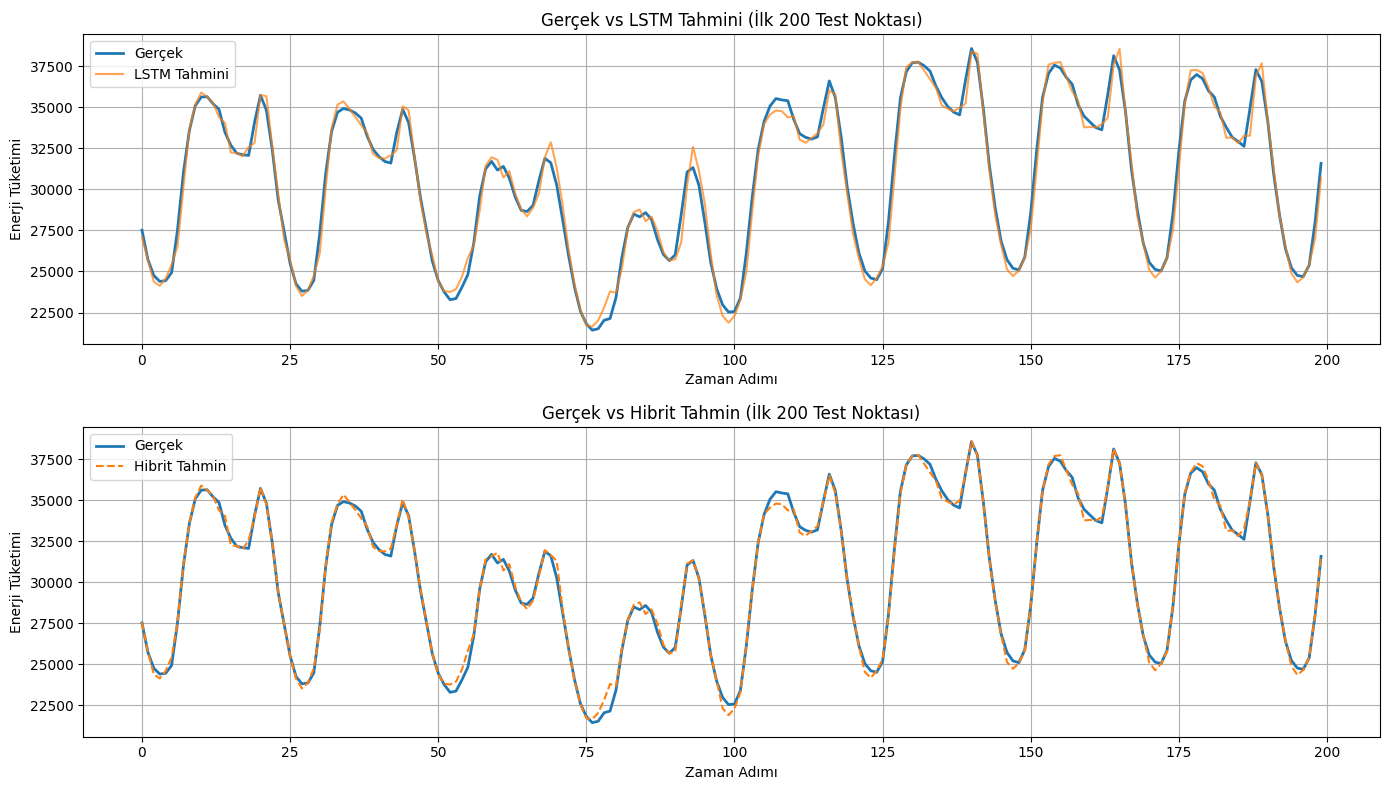

In [ ]:
 # Grafik: Her varyasyonun tahmini (istersen kaydedebilirsin)
plt.figure(figsize=(14, 8))

#Alt Grafik: Gerçek vs LSTM
plt.subplot(2, 1, 1)
plt.plot(true_test[:200], label='Gerçek', linewidth=2)
plt.plot(lstm_pred_true[:200], label='LSTM Tahmini', alpha=0.7)
plt.title("Gerçek vs LSTM Tahmini (İlk 200 Test Noktası)")
plt.xlabel("Zaman Adımı")
plt.ylabel("Enerji Tüketimi")
plt.legend()
plt.grid(True)

#Alt Grafik: Gerçek vs Hibrit
plt.subplot(2, 1, 2)
plt.plot(true_test[:200], label='Gerçek', linewidth=2)
plt.plot(final_pred_true[:200], label='Hibrit Tahmin', linestyle='--')
plt.title("Gerçek vs Hibrit Tahmin (İlk 200 Test Noktası)")
plt.xlabel("Zaman Adımı")
plt.ylabel("Enerji Tüketimi")
plt.legend()
plt.grid(True)
plt.tight_layout()
